# Clustering der männlichen Beobachtungen

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

In [2]:
heartData = pd.read_csv("heart-failure-prediction/heart.csv")
heartData.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# Entfernen unangegebener Cholersterin Beobachtungen und Frauen
heartData = heartData[(heartData["Sex"] != "F") & (heartData["Cholesterol"] != 0)]
heartData.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,53.102837,133.359929,241.040780,0.187943,138.040780,0.978191,0.560284
std,9.556603,16.842386,57.509194,0.391014,24.922903,1.096840,0.496793
min,28.000000,92.000000,85.000000,0.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,206.750000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,234.000000,0.000000,139.500000,0.800000,1.000000
75%,59.000000,140.000000,272.250000,0.000000,156.000000,1.800000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000


## Umwandlung in nummerische Werte und Standardisierung

In [4]:
# Umwandlung der Spalte "Sex" in nummerischen Wert
heartData["Sex"] = heartData["Sex"].apply(lambda x: 0 if x == "M" else 1)

# Umwandlung der Spalte "ST_Slope" in nummerischen Wert
heartData["ST_Slope"] = heartData["ST_Slope"].apply(lambda x: 0 if x == "Flat" else (1 if x == "Up" else 2))

# Umwandlung der Spalte "ChestPainType" in nummerischen Wert
heartData["ChestPainType"] = heartData["ChestPainType"].apply(lambda x: 0 if x == "TA" else (1 if x == "ATA" else (2 if x == "NAP" else 3)))

# Umwandlung der Spalte "RestingECG" in nummerischen Wert
heartData["RestingECG"] = heartData["RestingECG"].apply(lambda x: 0 if x == "Normal" else (1 if x == "ST" else 2))

# Umwandlung der Spalte "ExerciseAngina" in nummerischen Wert
heartData["ExerciseAngina"] = heartData["ExerciseAngina"].apply(lambda x: 0 if x == "N" else 1)

## Klassifizierung

### Person mit ungesunden Cholesterinspiegel

In [5]:
#    {"Age":53, "Sex":0, "ChestPainType":3, "RestingBP":120, "Cholesterol":180, "FastingBS":0,
#"RestingECG":0, "MaxHR":140, "Oldpeak":0.5, "ST_Slope":0, "label":"Gesunde Person"},

cholesterolPersons = heartData.query("240 <= Cholesterol <= 603").copy()
cholesterolPersons = cholesterolPersons.query("100 <= RestingBP <= 130")
cholesterolPersons = cholesterolPersons.query("100 <= MaxHR <= 140")
cholesterolPersons = cholesterolPersons.query("0 <= Oldpeak <= 1")
cholesterolPersons = cholesterolPersons.query("ChestPainType == 3")
cholesterolPersons = cholesterolPersons.query("RestingECG == 0")
cholesterolPersons = cholesterolPersons.query("FastingBS == 0")
cholesterolPersons = cholesterolPersons.query("ExerciseAngina == 0")

cholesterolPersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
18,60,0,3,100,248,0,0,125,0,1.0,0,1
76,32,0,3,118,529,0,0,130,0,0.0,0,1
91,39,0,3,130,307,0,0,140,0,0.0,1,0
145,39,0,3,110,273,0,0,132,0,0.0,1,0
153,55,0,3,120,270,0,0,140,0,0.0,1,0
196,49,0,3,120,297,0,0,132,0,1.0,0,0


In [6]:
heartData["label"] = None
heartData.loc[18,"label"] = 1
heartData.loc[76,"label"] = 1
heartData.loc[91,"label"] = 1
heartData.loc[145,"label"] = 1
heartData.loc[153,"label"] = 1
heartData.loc[196,"label"] = 1


#heartData["label"][18] = 1
#heartData["label"][76] = 1
#heartData["label"][91] = 1
#heartData["label"][145] = 1
#heartData["label"][153] = 1
#heartData["label"][196] = 1

### Personen mit zu Bluthochdruck

In [7]:
#    {"Age":53, "Sex":0, "ChestPainType":3, "RestingBP":120, "Cholesterol":180, "FastingBS":0,
#"RestingECG":0, "MaxHR":140, "Oldpeak":0.5, "ST_Slope":0, "label":"Gesunde Person"},

highBloodPressurePersons = heartData.query("200 <= Cholesterol <= 240")
highBloodPressurePersons = highBloodPressurePersons.query("130 <= RestingBP <= 200")
highBloodPressurePersons = highBloodPressurePersons.query("100 <= MaxHR <= 140")
highBloodPressurePersons = highBloodPressurePersons.query("0 <= Oldpeak <= 1")
highBloodPressurePersons = highBloodPressurePersons.query("ChestPainType == 3")
highBloodPressurePersons = highBloodPressurePersons.query("RestingECG == 0")
highBloodPressurePersons = highBloodPressurePersons.query("FastingBS == 0")
highBloodPressurePersons = highBloodPressurePersons.query("ExerciseAngina == 0")

highBloodPressurePersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
82,63,0,3,150,223,0,0,115,0,0.0,0,1,None
168,58,0,3,135,222,0,0,100,0,0.0,1,0,None
220,46,0,3,130,222,0,0,112,0,0.0,0,1,None


In [8]:
heartData.loc[82, "label"] = 2
heartData.loc[168, "label"] = 2
heartData.loc[220, "label"] = 2

### Personen mit zu hoher Herzfrequenz

In [9]:
#    {"Age":53, "Sex":0, "ChestPainType":3, "RestingBP":120, "Cholesterol":180, "FastingBS":0,
#"RestingECG":0, "MaxHR":140, "Oldpeak":0.5, "ST_Slope":0, "label":"Gesunde Person"},

HRPersons = heartData.query("200 <= Cholesterol <= 240")
HRPersons = HRPersons.query("100 <= RestingBP <= 130")
HRPersons = HRPersons.query("140 <= MaxHR <= 202")
HRPersons = HRPersons.query("0 <= Oldpeak <= 1")
HRPersons = HRPersons.query("ChestPainType == 3")
HRPersons = HRPersons.query("RestingECG == 0")
HRPersons = HRPersons.query("FastingBS == 0")
HRPersons = HRPersons.query("ExerciseAngina == 0")

HRPersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
46,37,0,3,120,223,0,0,168,0,0.0,1,0,None
79,49,0,3,130,206,0,0,170,0,0.0,0,1,None
209,54,0,3,125,216,0,0,140,0,0.0,0,1,None
270,45,0,3,120,225,0,0,140,0,0.0,1,0,None
638,47,0,3,112,204,0,0,143,0,0.1,1,0,None
709,52,0,3,125,212,0,0,168,0,1.0,1,1,None
712,58,0,3,100,234,0,0,156,0,0.1,1,1,None
761,52,0,3,112,230,0,0,160,0,0.0,1,1,None
779,43,0,3,110,211,0,0,161,0,0.0,1,0,None


In [10]:
#heartData["label"][209] = 3
heartData.loc[638, "label"] = 3
heartData.loc[712, "label"] = 3
heartData.loc[46, "label"] = 3
heartData.loc[209, "label"] = 3
heartData.loc[709, "label"] = 3
heartData.loc[761, "label"] = 3
heartData.loc[779, "label"] = 3

### ST Slope

In [11]:
slopePersons = heartData.query("200 <= Cholesterol <= 240")
slopePersons = slopePersons.query("100 <= RestingBP <= 130")
slopePersons = slopePersons.query("100 <= MaxHR <= 140")
#slopePersons = slopePersons.query("0 <= Oldpeak <= 1")
slopePersons = slopePersons.query("ChestPainType == 3")
slopePersons = slopePersons.query("RestingECG == 0")
#slopePersons = slopePersons.query("FastingBS == 0")
#slopePersons = slopePersons.query("ExerciseAngina == 0")
slopePersons = slopePersons.query("ST_Slope > 0")

slopePersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
270,45,0,3,120,225,0,0,140,0,0.0,1,0,None
462,59,0,3,122,233,0,0,117,1,1.3,2,1,None
534,59,0,3,125,222,0,0,135,1,2.5,2,1,None


In [12]:
heartData.loc[270,"label"] = 4
heartData.loc[462,"label"] = 4
heartData.loc[534,"label"] = 4

### Brustschmerzen

In [13]:
#    {"Age":53, "Sex":0, "ChestPainType":3, "RestingBP":120, "Cholesterol":180, "FastingBS":0,
#"RestingECG":0, "MaxHR":140, "Oldpeak":0.5, "ST_Slope":0, "label":"Gesunde Person"},

ChestPainPersons = heartData.query("200 <= Cholesterol <= 240")
ChestPainPersons = ChestPainPersons.query("100 <= RestingBP <= 130")
ChestPainPersons = ChestPainPersons.query("100 <= MaxHR <= 140")
ChestPainPersons = ChestPainPersons.query("Oldpeak <= 1")
ChestPainPersons = ChestPainPersons.query("ChestPainType < 3")
ChestPainPersons = ChestPainPersons.query("RestingECG == 0")
ChestPainPersons = ChestPainPersons.query("FastingBS == 0")
ChestPainPersons = ChestPainPersons.query("ExerciseAngina == 0")

ChestPainPersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
24,40,0,2,130,215,0,0,138,0,0.0,1,0,None
71,44,0,1,130,215,0,0,135,0,0.0,1,0,None
150,39,0,1,130,215,0,0,120,0,0.0,1,0,None
217,54,0,2,120,217,0,0,137,0,0.0,1,0,None
290,48,0,2,110,211,0,0,138,0,0.0,1,0,None


In [14]:
heartData.loc[24, "label"] = 5
heartData.loc[71, "label"] = 5
heartData.loc[150, "label"] = 5
heartData.loc[217, "label"] = 5
heartData.loc[290, "label"] = 5

### Oldpeak

In [15]:
OldPeakPersons = heartData.query("200 <= Cholesterol <= 240")
OldPeakPersons = OldPeakPersons.query("100 <= RestingBP <= 130")
OldPeakPersons = OldPeakPersons.query("100 <= MaxHR <= 140")
OldPeakPersons = OldPeakPersons.query("Oldpeak >= 1")
OldPeakPersons = OldPeakPersons.query("ChestPainType == 3")
OldPeakPersons = OldPeakPersons.query("RestingECG == 0")
OldPeakPersons = OldPeakPersons.query("FastingBS == 0")
OldPeakPersons = OldPeakPersons.query("ExerciseAngina == 0")

OldPeakPersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
32,54,0,3,125,224,0,0,122,0,2.0,0,1,None
846,39,0,3,118,219,0,0,140,0,1.2,0,1,None


In [16]:
heartData.loc[32, "label"] = 6
heartData.loc[846, "label"] = 6

### FastingBS

In [17]:
BSPersons = heartData.query("200 <= Cholesterol <= 240")
#BSPersons = BSPersons.query("100 <= RestingBP <= 130")
#BSPersons = BSPersons.query("100 <= MaxHR <= 140")
#BSPersons = BSPersons.query("Oldpeak <= 1")
BSPersons = BSPersons.query("ChestPainType == 3")
BSPersons = BSPersons.query("RestingECG == 0")
BSPersons = BSPersons.query("FastingBS == 1")
BSPersons = BSPersons.query("ExerciseAngina == 0")

BSPersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
599,56,0,3,130,203,1,0,98,0,1.5,0,1,None
802,52,0,3,108,233,1,0,147,0,0.1,1,0,None


In [18]:
heartData.loc[599, "label"] = 7
heartData.loc[802, "label"] = 7

### ExerciseAngina

In [19]:
anginaPersons = heartData.query("200 <= Cholesterol <= 240")
anginaPersons = anginaPersons.query("100 <= RestingBP <= 130")
anginaPersons = anginaPersons.query("100 <= MaxHR <= 140")
anginaPersons = anginaPersons.query("0 <= Oldpeak <= 1")
anginaPersons = anginaPersons.query("ChestPainType == 3")
anginaPersons = anginaPersons.query("RestingECG == 0")
anginaPersons = anginaPersons.query("FastingBS == 0")
anginaPersons = anginaPersons.query("ExerciseAngina > 0")
anginaPersons = anginaPersons.query("ST_Slope == 0")

anginaPersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
262,46,0,3,120,231,0,0,115,1,0.0,0,1,None


In [20]:
heartData.loc[262, "label"] = 8

### Alter

In [21]:
agedPersons = heartData.query("200 <= Cholesterol <= 240")
#agedPersons = agedPersons.query("100 <= RestingBP <= 130")
#agedPersons = agedPersons.query("100 <= MaxHR <= 140")
#agedPersons = agedPersons.query("Oldpeak <= 1")
agedPersons = agedPersons.query("ChestPainType == 3")
agedPersons = agedPersons.query("RestingECG == 0")
agedPersons = agedPersons.query("FastingBS == 0")
agedPersons = agedPersons.query("ExerciseAngina == 0")
agedPersons = agedPersons.query("ST_Slope == 0")
agedPersons = agedPersons.query("Age >= 59")

agedPersons

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,label
82,63,0,3,150,223,0,0,115,0,0.0,0,1,2
625,59,0,3,135,234,0,0,161,0,0.5,0,0,None
716,67,0,3,120,237,0,0,71,0,1.0,0,1,None


In [22]:
heartData.loc[625, "label"] = 9
heartData.loc[716, "label"] = 9

In [23]:
# Nummerische und Kategorie Attribute rausfiltern
numericFeatures = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categoricalFeatures = ["ChestPainType", "RestingECG", "ST_Slope"]
numericHeartData = heartData.loc[:,numericFeatures].copy()

In [24]:
categoricalZip = dict(zip(categoricalFeatures,["CP","ECG","ST"]))
for column, prefix in categoricalZip.items():
    dummies = pd.get_dummies(heartData[column], prefix=prefix)
    heartData = pd.concat([heartData, dummies], axis=1)
    heartData = heartData.drop(column, axis=1)

In [25]:
y = heartData["HeartDisease"]
x = heartData.drop("HeartDisease", axis=1).copy()
x = x.drop("label", axis=1).copy()
# Skalieren von 0 bis 1
x = pd.DataFrame(MinMaxScaler().fit_transform(x), columns=x.columns)
x

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,CP_0,CP_1,CP_2,CP_3,ECG_0,ECG_1,ECG_2,ST_0,ST_1,ST_2
0,0.244898,0.0,0.444444,0.393822,0.0,0.774436,0.0,0.017544,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.183673,0.0,0.351852,0.382239,0.0,0.218045,0.0,0.017544,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.530612,0.0,0.537037,0.212355,0.0,0.398496,0.0,0.017544,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.224490,0.0,0.259259,0.490347,0.0,0.759398,0.0,0.017544,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.530612,0.0,0.166667,0.237452,0.0,0.548872,0.0,0.017544,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0.632653,0.0,0.666667,0.175676,1.0,0.157895,0.0,0.192982,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
560,0.346939,0.0,0.166667,0.345560,0.0,0.473684,0.0,0.228070,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
561,0.816327,0.0,0.481481,0.208494,1.0,0.541353,0.0,0.614035,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
562,0.591837,0.0,0.351852,0.088803,0.0,0.345865,1.0,0.228070,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [26]:
x.describe()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,CP_0,CP_1,CP_2,CP_3,ECG_0,ECG_1,ECG_2,ST_0,ST_1,ST_2
count,564.000000,564.0,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,0.512303,0.0,0.382962,0.301237,0.187943,0.519104,0.437943,0.189156,0.056738,0.189716,0.207447,0.546099,0.595745,0.175532,0.228723,0.503546,0.429078,0.067376
std,0.195033,0.0,0.155948,0.111022,0.391014,0.187390,0.496574,0.192428,0.231546,0.392425,0.405838,0.498312,0.491183,0.380759,0.420384,0.500431,0.495384,0.250894
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367347,0.0,0.259259,0.235039,0.000000,0.383459,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.530612,0.0,0.351852,0.287645,0.000000,0.530075,0.000000,0.157895,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.632653,0.0,0.444444,0.361486,0.000000,0.654135,1.000000,0.333333,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Clustering

In [27]:
pca = PCA(n_components=2)
reduced_x = pd.DataFrame(pca.fit_transform(x), columns=["PC1","PC2"])
reduced_x["HeartDisease"] = heartData["HeartDisease"]
reduced_x["label"] = heartData["label"]

reduced_x

,PC1,PC2,HeartDisease,label
0,1.298224,-0.328382,0.0,None
1,0.970189,0.662630,NaN,NaN
2,1.121912,-0.226066,0.0,None
3,1.190732,-0.245881,NaN,NaN
4,1.258116,-0.319106,0.0,None
...,...,...,...,...
559,-0.775248,0.797607,1.0,None
560,0.024206,-0.508889,0.0,None
561,-0.578438,-0.470362,0.0,None
562,-0.864416,-0.715457,0.0,None


## Visualisierung

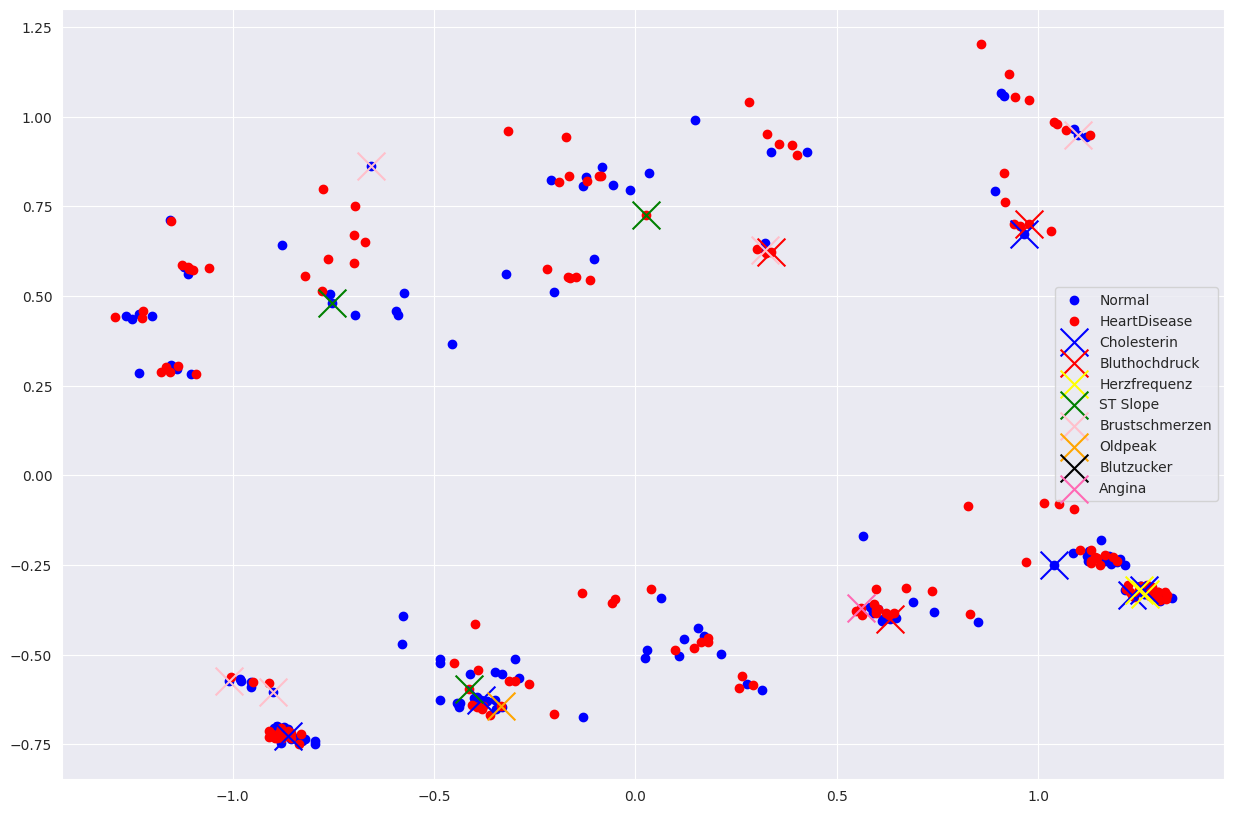

In [28]:
plt.figure(figsize=(15,10))

plt.scatter(reduced_x[reduced_x["HeartDisease"] == 0]["PC1"],reduced_x[reduced_x["HeartDisease"] == 0]["PC2"], color = "blue", label="Normal")
plt.scatter(reduced_x[reduced_x["HeartDisease"] == 1]["PC1"],reduced_x[reduced_x["HeartDisease"] == 1]["PC2"], color = "red", label="HeartDisease")

plt.scatter(reduced_x[reduced_x["label"] == 1]["PC1"],reduced_x[reduced_x["label"] == 1]["PC2"], color = "blue", marker = "x", label="Cholesterin", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 2]["PC1"],reduced_x[reduced_x["label"] == 2]["PC2"], color = "red", marker = "x", label="Bluthochdruck", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 3]["PC1"],reduced_x[reduced_x["label"] == 3]["PC2"], color = "yellow", marker = "x", label="Herzfrequenz", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 4]["PC1"],reduced_x[reduced_x["label"] == 4]["PC2"], color = "green", marker = "x", label="ST Slope", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 5]["PC1"],reduced_x[reduced_x["label"] == 5]["PC2"], color = "pink", marker = "x", label="Brustschmerzen", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 6]["PC1"],reduced_x[reduced_x["label"] == 6]["PC2"], color = "orange", marker = "x", label="Oldpeak", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 7]["PC1"],reduced_x[reduced_x["label"] == 7]["PC2"], color = "black", marker = "x", label="Blutzucker", s =400)
plt.scatter(reduced_x[reduced_x["label"] == 8]["PC1"],reduced_x[reduced_x["label"] == 8]["PC2"], color = "hotpink", marker = "x", label="Angina", s =400)
#plt.scatter(reduced_x[reduced_x["label"] == 9]["PC1"],reduced_x[reduced_x["label"] == 9]["PC2"], color = "yellow", marker = "x", label="Aged", s =1000)

#plt.scatter(reduced_x["PC1"], reduced_x["PC2"])

#plt.scatter(reduced_x[reduced_x["cluster"] == 0].loc[:, "PC1"],reduced_x[reduced_x["cluster"] == 0].loc[:, "PC2"], color = "red")
#plt.scatter(reduced_x[reduced_x["cluster"] == 1].loc[:, "PC1"],reduced_x[reduced_x["cluster"] == 1].loc[:, "PC2"], color = "blue")

plt.legend()

plt.show()

## Trainieren

In [29]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size = 0.8)

In [30]:
model = MLPClassifier(hidden_layer_sizes = (256, 256), max_iter = 500)
model.fit(xTrain,yTrain)

print(f"Model Accuracy: {model.score(xTest,yTest)}")

Model Accuracy: 0.8053097345132744
